In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder


In [5]:
df = pd.read_csv('cubic_zirconia.csv')

In [275]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


Rename the Columns

In [276]:
df = df.rename(columns={'carat': 'Carat', 'cut' :'Cut' ,'color' :'Color','clarity' : 'Clarity', 'depth' : 'Depth_percent',
                        'table' : 'Table_percent', 'x' : 'Length', 'y' : 'Width', 'z' : 'Height' , 'price' : 'Price'})

In [277]:
df.head()

,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [278]:
# Size of the dataset
df.shape

(26967, 11)

The data types for each column:
There are three categorical columns seven numerical columns

In [279]:
df.dtypes

Unnamed: 0         int64
Carat            float64
Cut               object
Color             object
Clarity           object
Depth_percent    float64
Table_percent    float64
Length           float64
Width            float64
Height           float64
Price              int64
dtype: object

In [280]:
df.nunique()

Unnamed: 0       26967
Carat              257
Cut                  5
Color                7
Clarity              8
Depth_percent      169
Table_percent      112
Length             531
Width              526
Height             356
Price             8742
dtype: int64

In [281]:
#Finding if there are any missing values
df.isnull().sum()

Unnamed: 0         0
Carat              0
Cut                0
Color              0
Clarity            0
Depth_percent    697
Table_percent      0
Length             0
Width              0
Height             0
Price              0
dtype: int64

There are 697 missing values in the depth percent feature

In [282]:
# show df where depth is null
missing_rows = df[df['Depth_percent'].isnull()]
missing_rows

# save the indexes
missing_indexes = missing_rows.index
print(missing_indexes)  # missing_indexes

Index([   26,    86,   117,   148,   163,   185,   258,   313,   344,   367,
       ...
       26574, 26590, 26720, 26780, 26827, 26848, 26854, 26879, 26923, 26960],
      dtype='int64', length=697)


In [283]:
df.Depth_percent

0        62.1
1        60.8
2        62.2
3        61.6
4        60.4
         ... 
26962    62.3
26963    61.9
26964    61.7
26965    61.8
26966    62.0
Name: Depth_percent, Length: 26967, dtype: float64

In [284]:
print(df['Depth_percent'].describe())


count    26270.000000
mean        61.745147
std          1.412860
min         50.800000
25%         61.000000
50%         61.800000
75%         62.500000
max         73.600000
Name: Depth_percent, dtype: float64


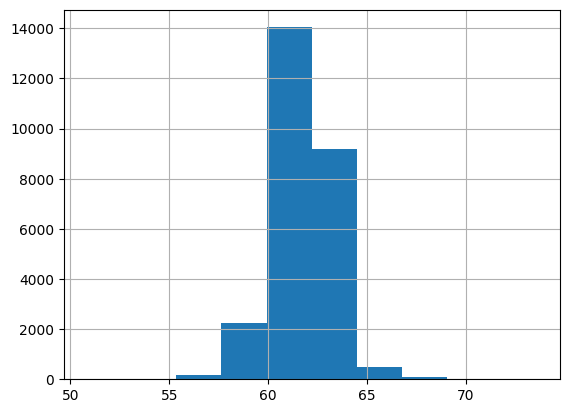

In [285]:
df['Depth_percent'].hist()
plt.show()

Seperating Numerical and Categorical features

In [286]:
num_columns = ['Carat','Depth_percent', 'Table_percent', 'Length', 'Width', 'Height']
cat_columns = [ 'Cut', 'Color', 'Clarity']

Finding the correlation between numerical features. To find if any other features has a strong correlation with 'Depth Percent'. 

In [287]:
correlation_matrix  = df[num_columns].corr()
print(correlation_matrix)

                  Carat  Depth_percent  Table_percent    Length     Width  \
Carat          1.000000       0.035364       0.181685  0.976368  0.941071   
Depth_percent  0.035364       1.000000      -0.298011 -0.018715 -0.024735   
Table_percent  0.181685      -0.298011       1.000000  0.196206  0.182346   
Length         0.976368      -0.018715       0.196206  1.000000  0.962715   
Width          0.941071      -0.024735       0.182346  0.962715  1.000000   
Height         0.940640       0.101624       0.148944  0.956606  0.928923   

                 Height  
Carat          0.940640  
Depth_percent  0.101624  
Table_percent  0.148944  
Length         0.956606  
Width          0.928923  
Height         1.000000  


Table percent and Height of the diamond has an effective correlation with Depth percent.

In [288]:
df_impute = df.copy()

The missing values can be replaced by the mean of the depth percent distribution. 
But here we will make use of the features which are correlated to the missing feature and try to predict the missing value for each data point. 

In [289]:
# Step 1: Define variables
predictor_variables = ['Table_percent', 'Height']
target_variable = 'Depth_percent'

# Step 3: Prepare data for regression model
train_data = df_impute[df_impute[target_variable].notnull()]
X_train = train_data[predictor_variables]
Y_train = train_data[target_variable]

# Step 4: Create and fit regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Step 5: Predict missing values
missing_data = df_impute[df_impute[target_variable].isnull()]
X_missing = missing_data[predictor_variables]
predictions = model.predict(X_missing)

# Step 6: Impute missing values in the original DataFrame
df_impute.loc[df_impute[target_variable].isnull(), target_variable] = predictions


In [290]:
# show data where depth was null before now it was imputed
check  = df_impute.loc[missing_indexes]
check['Depth_percent'].describe()

count    697.000000
mean      61.761444
std        0.596062
min       59.823823
25%       61.466924
50%       61.782377
75%       62.059555
max       70.963198
Name: Depth_percent, dtype: float64

<Axes: >

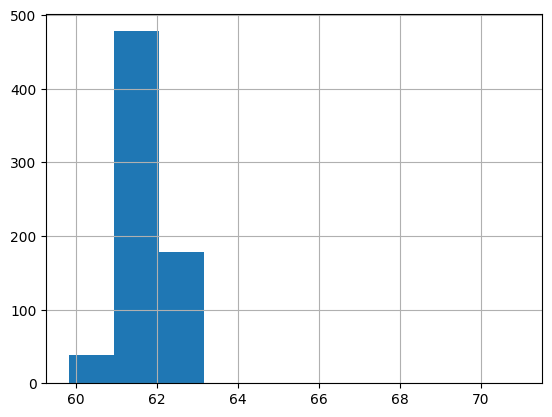

In [291]:
check['Depth_percent'].hist()

In [292]:
df_impute.isnull().sum()

Unnamed: 0       0
Carat            0
Cut              0
Color            0
Clarity          0
Depth_percent    0
Table_percent    0
Length           0
Width            0
Height           0
Price            0
dtype: int64

Descriptive statistics of numerical columns

In [293]:
df_impute[num_columns].describe()

,Carat,Depth_percent,Table_percent,Length,Width,Height
count,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,0.798375,61.745568,57.456080,5.729854,5.733569,3.538057
std,0.477745,1.397768,2.232068,1.128516,1.166058,0.720624
min,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000
25%,0.400000,61.100000,56.000000,4.710000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000
max,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000


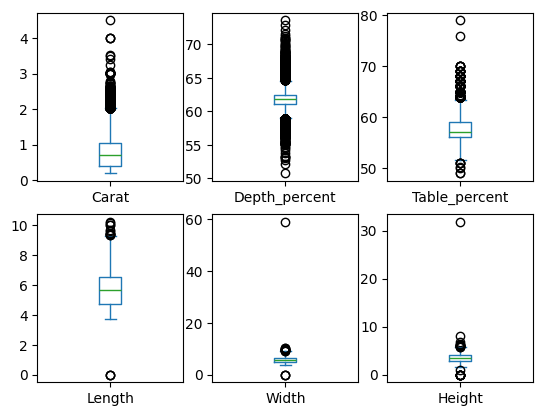

In [294]:
#box plots of numeric columns
df_impute[num_columns].plot(kind='box',subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

In [295]:
df_impute.head()

,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [296]:
# Percentage of values in different categorical columns pie chart

df_impute.groupby('Cut').size()/df.shape[0] * 100

Cut
Fair          2.896132
Good          9.051804
Ideal        40.108280
Premium      25.583120
Very Good    22.360663
dtype: float64

In [297]:
df_impute.groupby('Color').size()/df.shape[0] * 100

Color
D    12.400341
E    18.233396
F    17.536248
G    20.992324
H    15.211184
I    10.275522
J     5.350985
dtype: float64

In [298]:
df_impute.groupby('Clarity').size()/df.shape[0] * 100

Clarity
I1       1.353506
IF       3.315163
SI1     24.366819
SI2     16.965180
VS1     15.177810
VS2     22.616531
VVS1     6.819446
VVS2     9.385545
dtype: float64

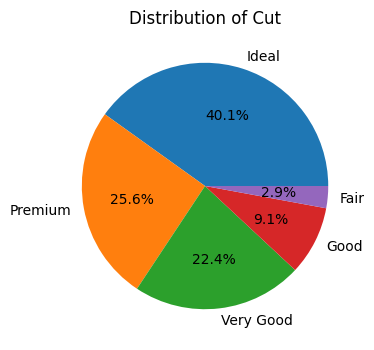

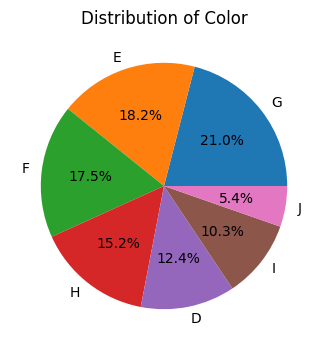

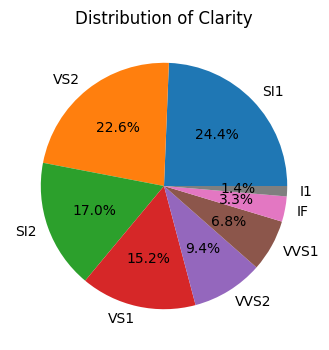

In [299]:
for column in cat_columns:
    counts = df_impute[column].value_counts()
    plt.figure(figsize=(6, 4))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(f'Distribution of {column}')
    plt.show()

In [300]:
df_impute.head()

,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


The length, width and height features can be combined to create a new feature volume and can be used instead of the three features. 

In [301]:
df_impute['Volume'] = df_impute['Length'] * df_impute['Width'] * df_impute['Height']
df_impute.head()

,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price,Volume
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499,48.726678
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984,53.225640
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289,139.726944
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082,68.482560
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779,51.066825


In [302]:
num_columns.append('Volume')

In [303]:
df_impute[num_columns].describe()

,Carat,Depth_percent,Table_percent,Length,Width,Height,Volume
count,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
mean,0.798375,61.745568,57.456080,5.729854,5.733569,3.538057,129.995827
std,0.477745,1.397768,2.232068,1.128516,1.166058,0.720624,80.420430
min,0.200000,50.800000,49.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.100000,56.000000,4.710000,4.710000,2.900000,64.774944
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,114.640110
75%,1.050000,62.500000,59.000000,6.550000,6.540000,4.040000,171.370890
max,4.500000,73.600000,79.000000,10.230000,58.900000,31.800000,3840.598060


Finding the ditribution of the numerical values. To determine if data needs to be normalised and standardised.


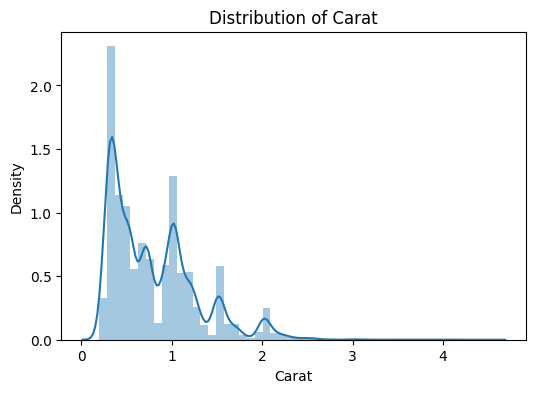

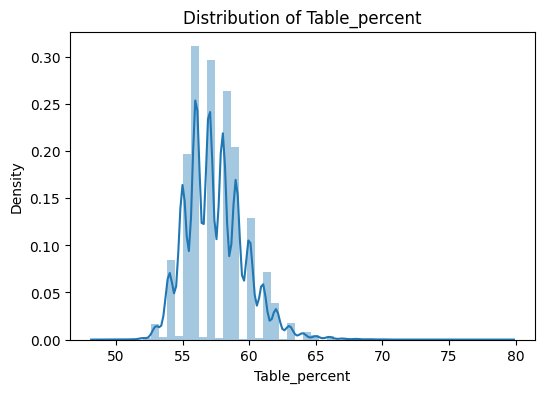

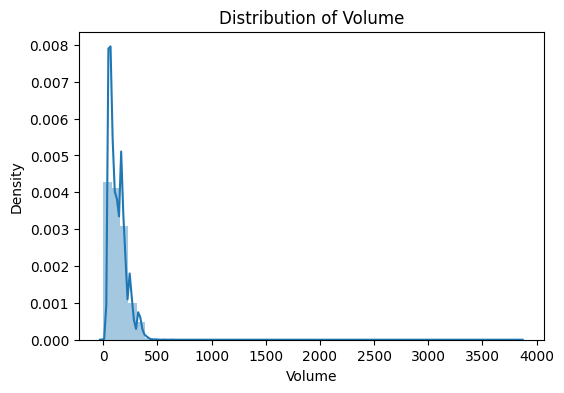

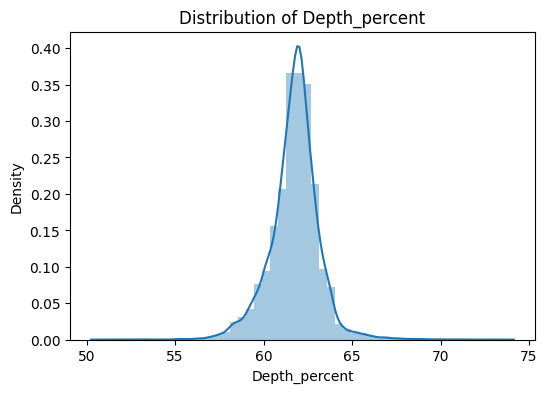

In [304]:
# check the distribution of numerical columns
num_columns1 = ['Carat', 'Table_percent', 'Volume', 'Depth_percent']
for column in num_columns1:
    plt.figure(figsize=(6, 4))
    sns.distplot(df_impute[column])
    plt.title(f'Distribution of {column}')
    plt.show()

We can log normalise the volume feature. And standardise Depth percent, table percent and volume percent after normalisation to get the data around zero mean so that it becomes easier for the models that will be used to find patterns.

In [305]:
df_scale = df_impute.copy()

Log normalizing the Volume feature since it is right skewed.

In [306]:
columns_to_log =['Volume']
df_scale[columns_to_log] = np.log1p(df_scale[columns_to_log])

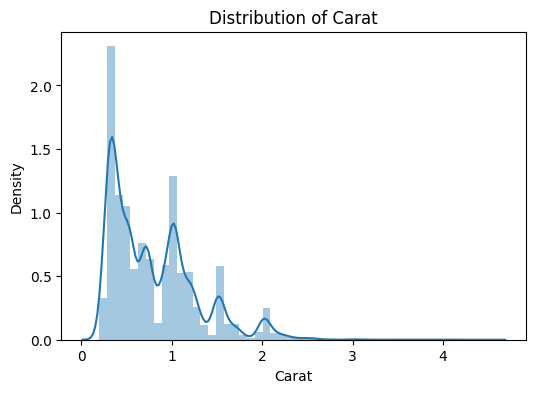

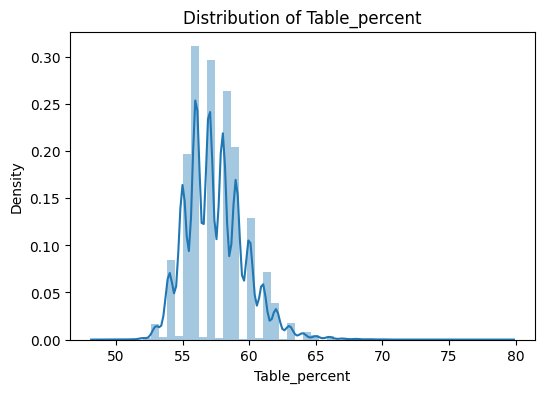

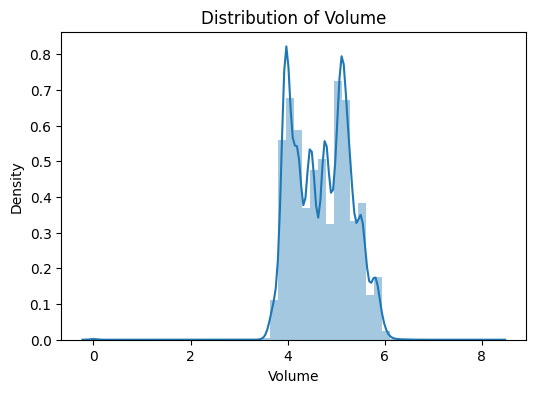

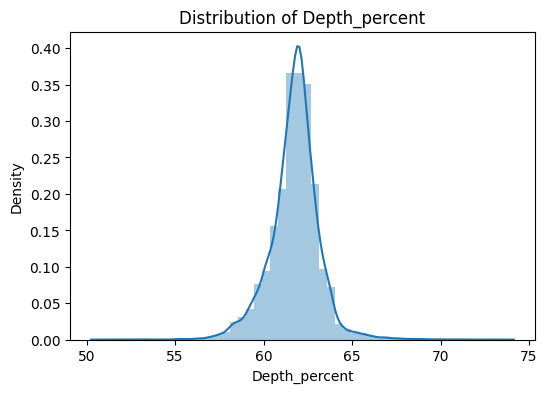

In [307]:
for column in num_columns1:
    plt.figure(figsize=(6, 4))
    sns.distplot(df_scale[column])
    plt.title(f'Distribution of {column}')
    plt.show()

Applying standard scaling method to standardise the three features mentioned

In [308]:
# Apply standardization and normalization
columns_to_scale = ['Table_percent', 'Volume','Depth_percent']

scaler = StandardScaler()
df_scale[columns_to_scale] = scaler.fit_transform(df_scale[columns_to_scale])
df_scale.head()

,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price,Volume
0,1,0.30,Ideal,E,SI1,0.253575,0.243689,4.27,4.29,2.66,499,-1.373034
1,2,0.33,Premium,G,IF,-0.676497,0.243689,4.42,4.46,2.70,984,-1.224584
2,3,0.90,Very Good,E,VVS2,0.325119,1.139736,6.04,6.12,3.78,6289,0.409960
3,4,0.42,Ideal,F,VS1,-0.104145,-0.652358,4.82,4.80,2.96,1082,-0.799657
4,5,0.31,Ideal,F,VVS1,-0.962673,0.691712,4.35,4.43,2.65,779,-1.294215


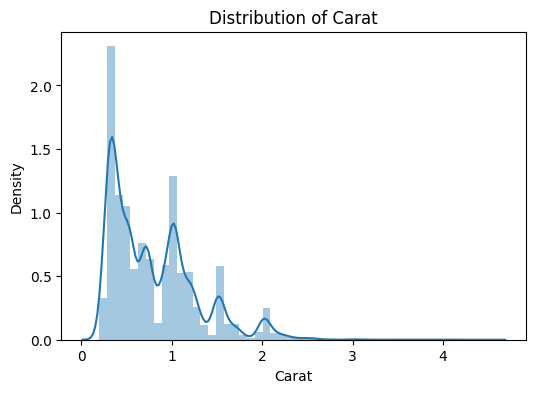

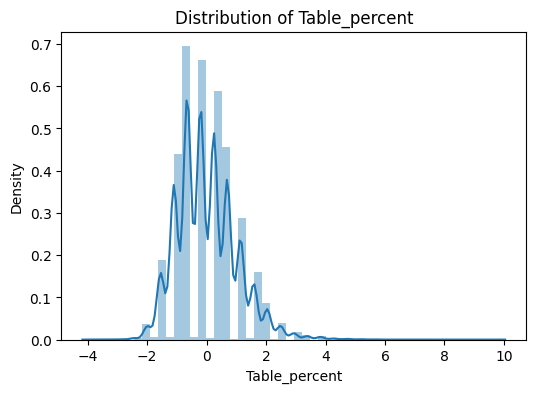

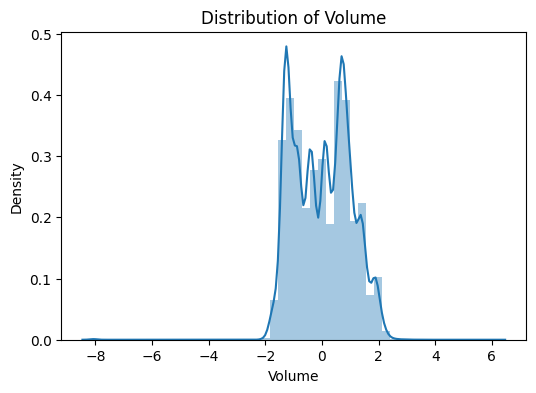

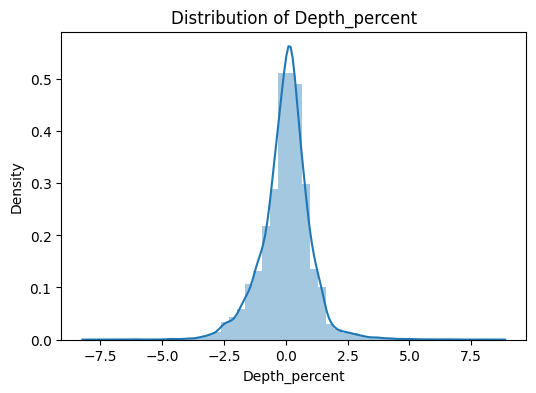

In [309]:
for column in num_columns1:
    plt.figure(figsize=(6, 4))
    sns.distplot(df_scale[column])
    plt.title(f'Distribution of {column}')
    plt.show()

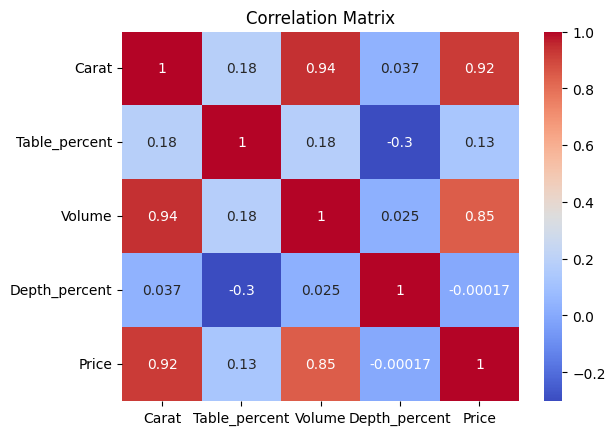

In [310]:
# Find correlation between numeric columns and target variable
cor_col = ['Carat', 'Table_percent', 'Volume', 'Depth_percent', 'Price']
correlation_matrix = df_scale[cor_col].corr()

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We can see that Carat and Volume of the diamond has strong correlation with Price of the diamond. 

In [311]:
df_encode = df_scale.copy()

In [312]:
df_encode['Clarity'].value_counts()

Clarity
SI1     6571
VS2     6099
SI2     4575
VS1     4093
VVS2    2531
VVS1    1839
IF       894
I1       365
Name: count, dtype: int64

Since the categorical features indicates the quality from best to worst of that feature. It is ideal to use ordinal encoding to make the best use of these features.

In [313]:
#Encode categorical columns
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity_order = [
    'I3',   # Included 3 - Worst clarity
    'I2',   # Included 2
    'I1',   # Included 1
    'SI2',  # Slightly Included 2
    'SI1',  # Slightly Included 1
    'VS2',  # Very Slightly Included 2
    'VS1',  # Very Slightly Included 1
    'VVS2', # Very, Very Slightly Included 2
    'VVS1', # Very, Very Slightly Included 1
    'IF',   # Internally Flawless
    'FL'    # Flawless - Best clarity
]

ordinal_encoder = OrdinalEncoder(categories=[color_order, cut_order, clarity_order])

# Fit and transform the data
df_encode[['Color_enc', 'Cut_enc', 'Clarity_enc']] = ordinal_encoder.fit_transform(df_encode[['Color','Cut', 'Clarity']])
df_encode.head()


,Unnamed: 0,Carat,Cut,Color,Clarity,Depth_percent,Table_percent,Length,Width,Height,Price,Volume,Color_enc,Cut_enc,Clarity_enc
0,1,0.30,Ideal,E,SI1,0.253575,0.243689,4.27,4.29,2.66,499,-1.373034,5.0,4.0,4.0
1,2,0.33,Premium,G,IF,-0.676497,0.243689,4.42,4.46,2.70,984,-1.224584,3.0,3.0,9.0
2,3,0.90,Very Good,E,VVS2,0.325119,1.139736,6.04,6.12,3.78,6289,0.409960,5.0,2.0,7.0
3,4,0.42,Ideal,F,VS1,-0.104145,-0.652358,4.82,4.80,2.96,1082,-0.799657,4.0,4.0,6.0
4,5,0.31,Ideal,F,VVS1,-0.962673,0.691712,4.35,4.43,2.65,779,-1.294215,4.0,4.0,8.0


Creating the final Dataset afte all the data preprocessing to be used for training and testing purposes.

In [314]:
final_df = df_encode.drop(['Unnamed: 0', 'Color', 'Cut', 'Clarity','Length', 'Width', 'Height'], axis=1)
final_df.head()

,Carat,Depth_percent,Table_percent,Price,Volume,Color_enc,Cut_enc,Clarity_enc
0,0.30,0.253575,0.243689,499,-1.373034,5.0,4.0,4.0
1,0.33,-0.676497,0.243689,984,-1.224584,3.0,3.0,9.0
2,0.90,0.325119,1.139736,6289,0.409960,5.0,2.0,7.0
3,0.42,-0.104145,-0.652358,1082,-0.799657,4.0,4.0,6.0
4,0.31,-0.962673,0.691712,779,-1.294215,4.0,4.0,8.0


In [315]:
print(final_df['Color_enc'].unique(), final_df['Color_enc'].nunique())
print(final_df['Cut_enc'].unique(), final_df['Cut_enc'].nunique())
print(final_df['Clarity_enc'].unique(), final_df['Clarity_enc'].nunique())


[5. 3. 4. 6. 2. 0. 1.] 7
[4. 3. 2. 1. 0.] 5
[4. 9. 7. 6. 8. 5. 3. 2.] 8


Creating input and the target variable.

In [316]:
feauture_cols = ['Carat', 'Color_enc', 'Cut_enc', 'Clarity_enc', 'Table_percent', 'Volume', 'Depth_percent']

X = final_df[feauture_cols]
y = final_df['Price']
X.head()

,Carat,Color_enc,Cut_enc,Clarity_enc,Table_percent,Volume,Depth_percent
0,0.30,5.0,4.0,4.0,0.243689,-1.373034,0.253575
1,0.33,3.0,3.0,9.0,0.243689,-1.224584,-0.676497
2,0.90,5.0,2.0,7.0,1.139736,0.409960,0.325119
3,0.42,4.0,4.0,6.0,-0.652358,-0.799657,-0.104145
4,0.31,4.0,4.0,8.0,0.691712,-1.294215,-0.962673


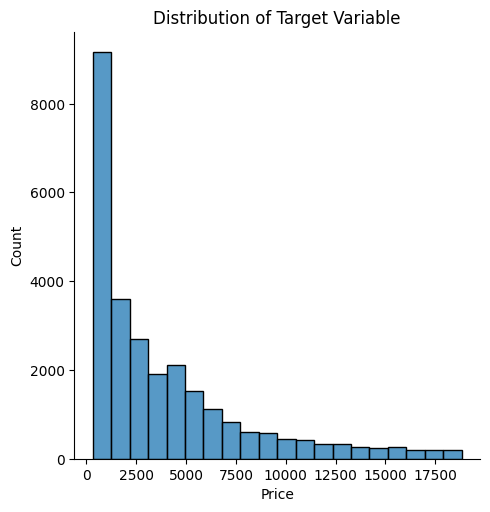

In [317]:
#plot the distribution of the target variable
sns.displot(y,bins=20, kde_kws={'shade': True})
plt.title('Distribution of Target Variable')
plt.show()

In [318]:
y.describe()

count    26967.000000
mean      3939.518115
std       4024.864666
min        326.000000
25%        945.000000
50%       2375.000000
75%       5360.000000
max      18818.000000
Name: Price, dtype: float64

Splitting data into training and testing dataset. Using stratfied split to maintain the means of target variable in both train and test split and distributon similar. 

In [319]:
bins = pd.qcut(y, q=4, labels=False)  # Binned target for stratification

# Stratified split using quantile bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=bins, random_state=42
)

In [320]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [321]:
y_test.describe()


count     5394.000000
mean      3925.129032
std       4001.370664
min        336.000000
25%        945.000000
50%       2375.000000
75%       5360.250000
max      18787.000000
Name: Price, dtype: float64

In [322]:
y_train.describe()

count    21573.000000
mean      3943.115886
std       4030.801894
min        326.000000
25%        945.000000
50%       2373.000000
75%       5359.000000
max      18818.000000
Name: Price, dtype: float64

In [323]:
X_train.head()

,Carat,Color_enc,Cut_enc,Clarity_enc,Table_percent,Volume,Depth_percent
16377,1.00,3.0,1.0,3.0,1.139736,0.679062,-3.108991
22587,0.90,4.0,1.0,4.0,0.243689,0.454701,0.611295
11442,1.50,2.0,2.0,7.0,0.691712,1.353675,0.825927
23458,2.66,2.0,1.0,3.0,-0.204334,2.277482,1.469822
14844,1.56,2.0,4.0,5.0,-0.652358,1.451311,-0.175689


Training the regression models. The models considered are linear regressor, decesion tree, random forest and XGBoost Regressor. The evaluation metrics used is r2 score.

In [324]:
# train the models
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor()
    }

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("-"*20)

Model: Random Forest
RMSE: 588.4573046564093
R2 Score: 0.978368189448752
--------------------
Model: Decision Tree
RMSE: 801.6065430881436
R2 Score: 0.959859251981943
--------------------
Model: Linear Regression
RMSE: 1211.9990625546684
R2 Score: 0.9082370171775422
--------------------
Model: XGBoost
RMSE: 562.2577313065816
R2 Score: 0.9802514910697937
--------------------


After training and testing the 4 models mentioned above we can see that the performance of the XGBoost is better than the rest with a r2 score of 0.9802